In [1]:
import json
import xarray as xr
import rioxarray
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
from fiweps.util import coordutil as co

## Config & prep

### Paths 

In [2]:
configdir = Path("../config/dscale/")

with open(configdir / "domains_03_extent.json") as src:
    extent = json.load(src)
extent

{'d01': {'west': 161, 'east': -108, 'north': 76, 'south': 50},
 'd02': {'west': -178, 'east': -128, 'north': 72, 'south': 55}}

In [3]:
co.deg180_360(extent['d01']['east'])

252

In [4]:
maskdir = Path("/Volumes/CWMobileSSD/Climate/ERA5/masks/")
datadirJRA = Path("/Volumes/CWMobileSSD/Climate/JRA55/snow")
january_JRA55 = datadirJRA / "anl_land.065_snwe.reg_tl319.2021010100_2021013118"
april_JRA55 = datadirJRA / "anl_land.065_snwe.reg_tl319.2021040100_2021043018"
june_JRA55 = datadirJRA / "anl_land.065_snwe.reg_tl319.2021060100_2021063018"
datadirERA = Path("/Volumes/CWMobileSSD/Climate/ERA5/sd_grib")
january_ERA5 = datadirERA / "e5.oper.an.sfc.128_141_sd.ll025sc.2021010100_2021013123.grb"
april_ERA5 = datadirERA / "e5.oper.an.sfc.128_141_sd.ll025sc.2021040100_2021043023.grb"
june_ERA5 = datadirERA / "e5.oper.an.sfc.128_141_sd.ll025sc.2021060100_2021063023.grb"
datadirNC = Path("/Volumes/CWMobileSSD/Climate/ERA5/sd_netcdf/")

julysnowfiles = sorted(list(datadirNC.glob('*07.nc')))
aprilsnowfiles = sorted(list(datadirERA.glob('*04.nc')))

### Helpers

In [5]:
def get_2Dtemplate(ds, roimask_in=None):
    template_data = np.ones((len(ds.latitude), len(ds.longitude)))
    template_lats = ds.latitude
    template_lons = ds.longitude
    templateDS = xr.DataArray(template_data, 
        coords=[template_lats, template_lons], 
        dims=["latitude", "longitude"])
    if roimask_in is not None:
        templateDS = templateDS.where(roimask_in==1)
    return templateDS

### Get glacier mask

In [6]:
with xr.load_dataset(maskdir / "glaciermask_thresh_1m.nc") as ds:
    glaciermask = ds.glaciermask
glaciermask

<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    crs        <U1 ''
Attributes:
    title:        ERA5-gridded glacier mask for threshold=1.0 for snow water ...
    institution:  International Arctic Research Center, UAF
    source:       Python, data file version  0.9
    author:       Chris Waigl cwaigl@alaska.edu 
    history:      2023-02-02 04:49:39.775844

## Load ERA5 and JRA55 data and generate syntetic snow

In [7]:
julysnowfiles

[PosixPath('/Volumes/CWMobileSSD/Climate/ERA5/sd_netcdf/reanalysis-era5-single-levels_sd_2021_07.nc')]

In [ ]:
with xr.open_dataset(julysnowfiles[20], chunks='auto') as ds:
    july_sd_era5 = ds.sd.isel(time=0)

july_sd_era5.where(glaciermask == 1)
july_sd_era5

IndexError: list index out of range

In [ ]:
projection = ccrs.AlbersEqualArea(
central_longitude=-154.0, central_latitude=50.0, 
standard_parallels=(55.0, 65.0))



JRA55_pths = sorted(datadirJRA.glob("anl_land.065_*8"))
ERA5_pths = sorted(datadirERA.glob("e5.oper.an.sfc*.grb"))
datapairs = list(zip(JRA55_pths, ERA5_pths))[:1] 
fig, axs = plt.subplots(nrows=len(datapairs),ncols=2,
                        subplot_kw={'projection': projection},
                        figsize=(15,5))
for ax in axs.flatten():
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')

for idx, dsJRA, dsERA in enumerate(datapairs): 
    with xr.open_dataset(dsERA, engine="cfgrib") as ds_ERA:
        with xr.open_dataset(dsJRA, engine="cfgrib") as ds_JRA:
            
            ds_JRA_ERA = ds_JRA_ERA.fillna(0).interp(
                latitude=ds_ERA.latitude, longitude=ds_ERA.longitude, method='nearest') / 1000
            combined_DS = ds_ERA.sd.where(templateDS==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))

SyntaxError: invalid syntax (3265822978.py, line 10)

month number 1
month number 2
month number 3


Can't read index file '/Volumes/CWMobileSSD/Climate/ERA5/sd_grib/e5.oper.an.sfc.128_141_sd.ll025sc.2021040100_2021043023.grb.923a8.idx'
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 429, in from_indexpath
    index = pickle.load(file)
            ^^^^^^^^^^^^^^^^^
EOFError: Ran out of input


month number 4
month number 5
month number 6


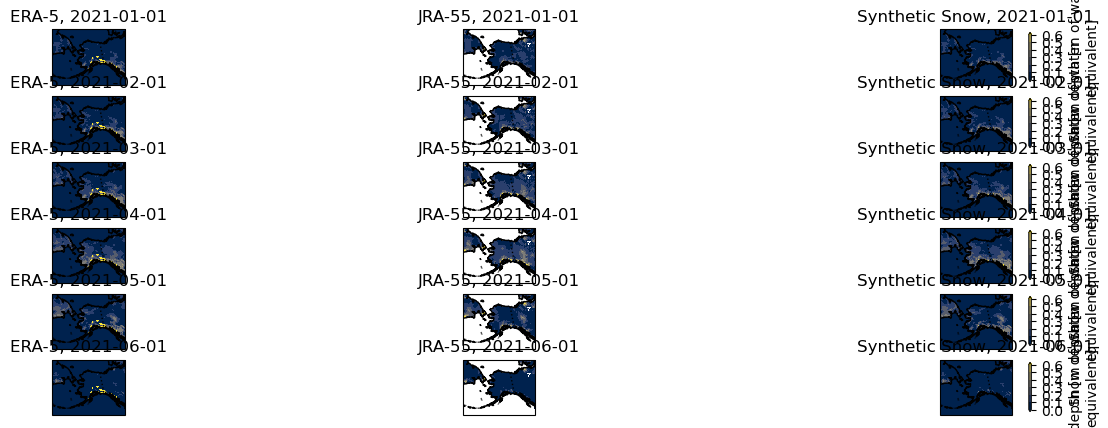

In [ ]:
projection = ccrs.AlbersEqualArea(
central_longitude=-154.0, central_latitude=50.0, 
standard_parallels=(55.0, 65.0))


JRA55_pths = sorted(datadirJRA.glob("anl_land.065_*8"))
ERA5_pths = sorted(datadirERA.glob("e5.oper.an.sfc*.grb"))
datapairs = list(zip(JRA55_pths, ERA5_pths))
fig, axs = plt.subplots(nrows=len(datapairs),ncols=3,
                        subplot_kw={'projection': projection},
                        figsize=(15,5))
for ax in axs.flatten():
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')


for idx, (dsJRA, dsERA) in enumerate(datapairs): 
    print(f"month number {idx+1}")
    with xr.open_dataset(dsERA, engine="cfgrib") as ds_ERA:
        with xr.open_dataset(dsJRA, engine="cfgrib") as ds_JRA:
            ds_ERA.sd.isel(time=0).plot(
                cmap=cmap, norm=norm, 
                add_colorbar=False,
#                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][0],
            )
            axs[idx][0].set_title(f"ERA-5, {ds_ERA.time[0].dt.strftime('%Y-%m-%d').data}")
            plotraster = ds_JRA.sd.isel(time=0) / 1000
            plotraster.plot(
                cmap=cmap, norm=norm, 
                add_colorbar=False,
#                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][1],
            )
            axs[idx][1].set_title(f"JRA-55, {ds_JRA.time[0].dt.strftime('%Y-%m-%d').data}")
            ds_JRA_ERA = ds_JRA.fillna(0).interp(
                latitude=ds_ERA.latitude, longitude=ds_ERA.longitude, method='nearest') / 1000
            combined_DS = ds_ERA.sd.where(templateDS==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))
            combined_DS.sd.plot(
                cmap=cmap, norm=norm, 
                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][2],
            )
            axs[idx][2].set_title(f"Synthetic Snow, {ds_JRA.time[0].dt.strftime('%Y-%m-%d').data}")
            




## make glacier mask

In [ ]:
ds = xr.open_dataset(datadirNC / "reanalysis-era5-single-levels_sd_2021_04.nc")
july_sd_era5 = ds.sd.mean(dim="time")
july_sd_era5.where(july_sd_era5 > 0.1)

<xarray.DataArray 'sd' (latitude: 721, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.],
       [10., 10., 10., ..., 10., 10., 10.]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

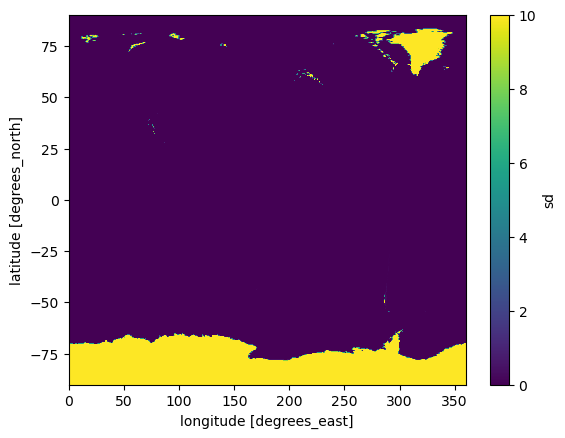

In [ ]:
july_sd_era5.plot()

In [ ]:
template_data = np.ones((len(ds.latitude), len(ds.longitude)))
template_lats = ds.latitude
template_lons = ds.longitude
templateDS = xr.DataArray(template_data, 
    coords=[template_lats, template_lons], 
    dims=["latitude", "longitude"])
templateDS

<xarray.DataArray (latitude: 721, longitude: 1440)>
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

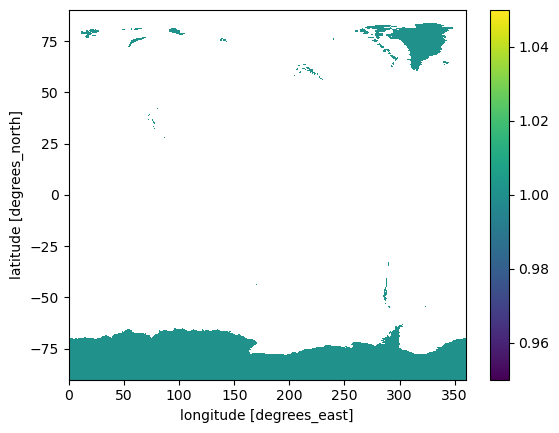

In [ ]:
templateDS = templateDS.where(july_sd_era5 > 0.1, 0)
templateDS.where(templateDS==1).plot()

In [ ]:
templateDS

<xarray.DataArray (latitude: 721, longitude: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [ ]:
maskoutdir = Path("/Volumes/CWMobileSSD/Climate/ERA5/masks/")

In [ ]:
ds_ERA = xr.open_dataset(datadirNC / "reanalysis-era5-single-levels_sd_2021_06.nc")


In [ ]:
ds_ERA.sd.isel(time=0)

<xarray.DataArray 'sd' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2021-07-01
Attributes:
    units:          m of water equivalent
    long_name:      Snow depth
    standard_name:  lwe_thickness_of_surface_snow_amount

In [ ]:
ds = xr.open_dataset(june_JRA55, engine="cfgrib")
ds.sd.isel(time=0)

<xarray.DataArray 'sd' (latitude: 320, longitude: 640)>
[204800 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 2021-06-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.57 89.01 88.45 ... -88.45 -89.01 -89.57
  * longitude   (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    valid_time  datetime64[ns] ...
Attributes: (12/24)
    GRIB_paramId:                             228141
    GRIB_numberOfPoints:                      204800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_gg
    ...                                       ...
    GRIB_name:                                Snow depth water equivalent
    GRIB_shortName:                           sd
    GRIB_units:                               kg m**-2
    long_name:                                Snow depth water equivalent
    units:                                    kg m**-2
    standard_name:                            unknown

In [ ]:
ds.sd

<xarray.DataArray 'sd' (time: 120, latitude: 320, longitude: 640)>
[24576000 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 2021-06-01 ... 2021-06-30T18:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.57 89.01 88.45 ... -88.45 -89.01 -89.57
  * longitude   (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    valid_time  (time) datetime64[ns] ...
Attributes: (12/24)
    GRIB_paramId:                             228141
    GRIB_numberOfPoints:                      204800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_gg
    ...                                       ...
    GRIB_name:                                Snow depth water equivalent
    GRIB_shortName:                           sd
    GRIB_units:                               kg m**-2
    long_name:                                Snow depth water equivalent
    units:                                    kg m**-2
    standard_name:                            unknown

In [ ]:
ds_ERA.sd.shape

(720, 721, 1440)

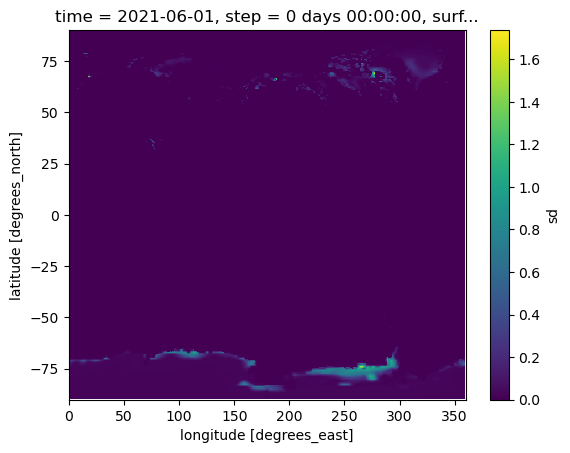

In [ ]:
ds_JRA_ERA = ds.fillna(0).interp(
    latitude=ds_ERA.latitude, longitude=ds_ERA.longitude, method='nearest') / 1000
ds_JRA_ERA.sd.isel(time=0).plot()

In [ ]:
combined_DS = ds_ERA.sd.where(templateDS==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))
combined_DS.sd.max()

NameError: name 'ds_ERA' is not defined

In [ ]:
bins = np.arange(0, 0.7, 0.1)
cmap = plt.get_cmap('cividis', len(bins))
#cmap = mpl.colors.ListedColormap(cmap.colors[[0] + idx])
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors)-1 )

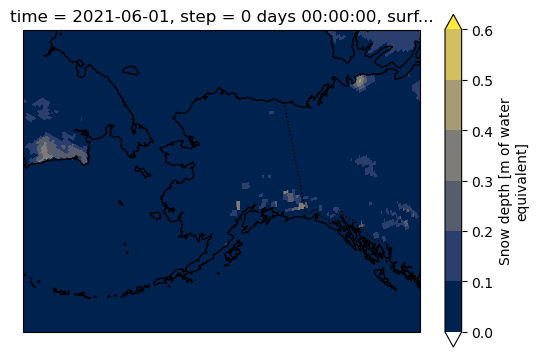

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
combined_DS.sd.plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

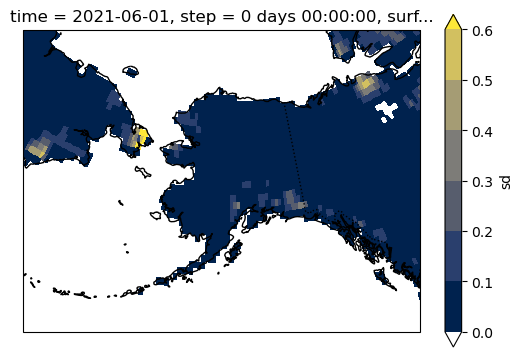

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
plotraster = ds.sd.isel(time=0) / 1000
plotraster.plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

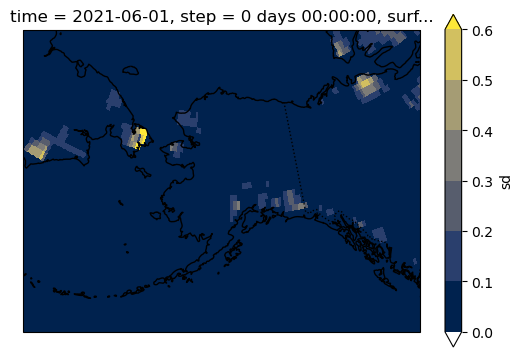

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_JRA_ERA.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

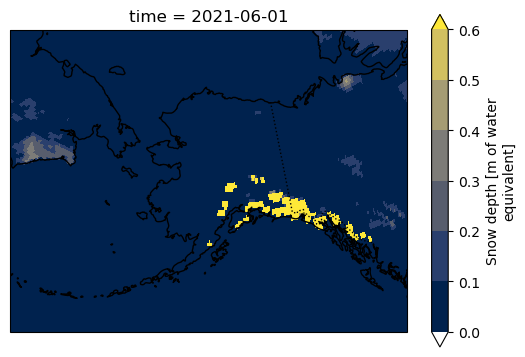

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_ERA.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

< GeoAxes: +proj=aea +ellps=WGS84 +lon_0=-154.0 +lat_0=50.0 +x_0=0.0 +y_0=0.0 +lat_1=55.0 +lat_2=65.0 +no_defs +type=crs >


Can't read index file '/Volumes/CWMobileSSD/Climate/ERA5/sd_grib/e5.oper.an.sfc.128_141_sd.ll025sc.2021040100_2021043023.grb.923a8.idx'
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 429, in from_indexpath
    index = pickle.load(file)
            ^^^^^^^^^^^^^^^^^
EOFError: Ran out of input


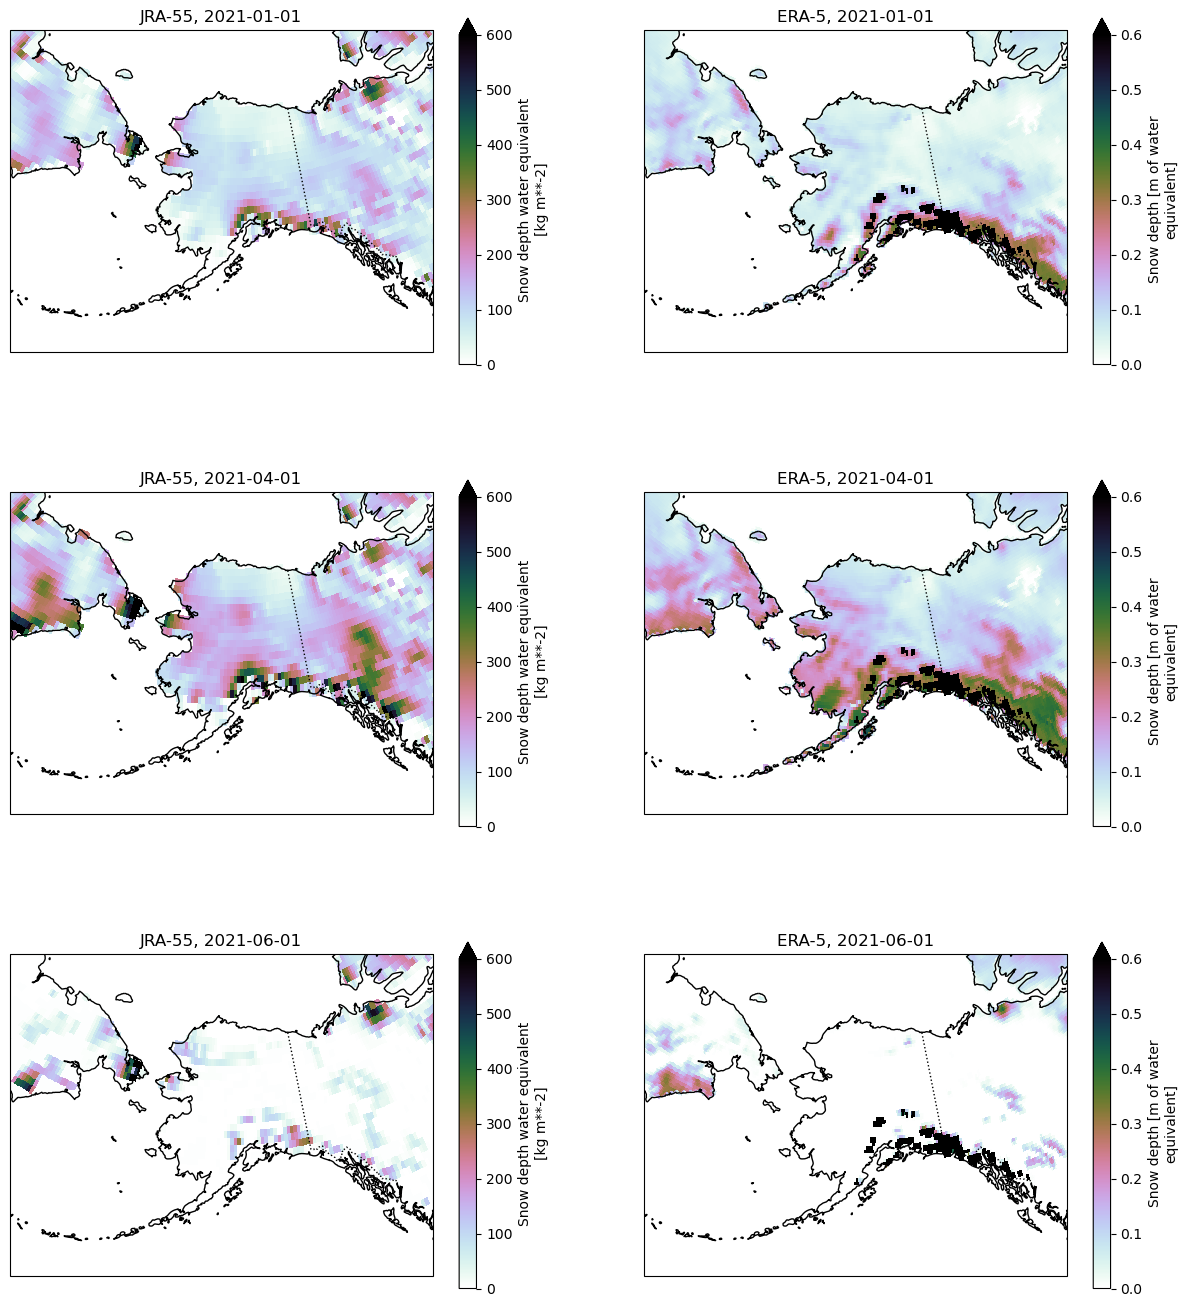

In [ ]:
fig, axs = plt.subplots(nrows=3,ncols=2,
                        subplot_kw={'projection': projection},
                        figsize=(15,17))
for ax in axs.flatten():
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')

with xr.open_dataset(january_JRA55, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[0][0],
        vmax=600
    )
    axs[0][0].set_title(f"JRA-55, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(april_JRA55, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[1][0],
        vmax=600
    )
    axs[1][0].set_title(f"JRA-55, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(june_JRA55, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[2][0],
        vmax=600
    )
    axs[2][0].set_title(f"JRA-55, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(january_ERA5, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[0][1],
        vmax=0.6
    )
    axs[0][1].set_title(f"ERA-5, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(april_ERA5, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[1][1],
        vmax=0.6
    )
    axs[1][1].set_title(f"ERA-5, {ds.time[0].dt.strftime('%Y-%m-%d').data}")
with xr.open_dataset(june_ERA5, engine="cfgrib") as ds:
    ds.sd.isel(time=0).plot(
        cmap=plt.cm.cubehelix_r, cbar_kwargs={"shrink": 0.9},
        transform=ccrs.PlateCarree(),
        ax=axs[2][1],
        vmax=0.6
    )
    axs[2][1].set_title(f"ERA-5, {ds.time[0].dt.strftime('%Y-%m-%d').data}")

In [ ]:
outdir = Path("/Volumes/CWMobileSSD/Climate/figures")
fig.savefig(outdir / "JRA55_ERA5_SWE_comp01.png", bbox_inches="tight", dpi=200, facecolor='white')